## GPT Architecture

Before we start implementing the GPT2 architecture let's code the configurations of the GPT2 model in a Python dictionary

In [1]:
GPT2_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
}

As we can see, the GPT2 model has a vocabulary size of 50257, and a context length of 1024 tokens. Moreover, the size token embeddings are 768 dimensional vectors. Finally we have 12 self-attention heads and the transformer block is repeated 12 times.

Now we need to put everything we talked about before together step by step. Let $x$ be a token that is going to go through our LLM. First, this token will be transformed to an embedding $x$ by an Embedding layer of size (vocab_size, emb_dim). Then $x$ will be added to a positional embedding that is obtained by another Embedding layer. After this, we apply dropout to $x$, and use it as input to our transformer block. Finally $x$ will be normalized and used as input to a Linear layer of size (emb_dim, vocab_size).

Below is the general structure

In [2]:
import torch
import torch.nn as nn

class GPTModel1(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.dropout = nn.Dropout(config["drop_rate"])

        self.transformer_block = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])] 
        )

        self.final_normalization = NormalizationLayer(config["emb_dim"])
        
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

    def forward(self, input_IDs):
        batch_size, seq_len = input_IDs.shape
        token_embeds = self.token_emb(input_IDs)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=input_IDs.device))

        x = token_embeds + pos_embeds
        x = self.dropout(x)
        x = self.transformer_block(x)
        x = self.final_normalization(x)
        y = self.out_head(x)
        return y
    

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

    def forward(self, x):
        return x
    

class NormalizationLayer(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x


Let's now talk about normalization

## Normalization

The process of training a deep neural network is challenging due to problems like vanishing or exploding gradients, which make updating the internal weights of the model more difficult. Due to this problem techniques such as normalization which stabilizes the training of a neural network are utilized.

The idea behind normalization is to adjust the activations (outputs) of a neural network to have a mean of zero and a variance of 1. This speeds up convergence. In  GPT2, normalization is usually applied before and after the multi-head attention module, and before the final output layer.

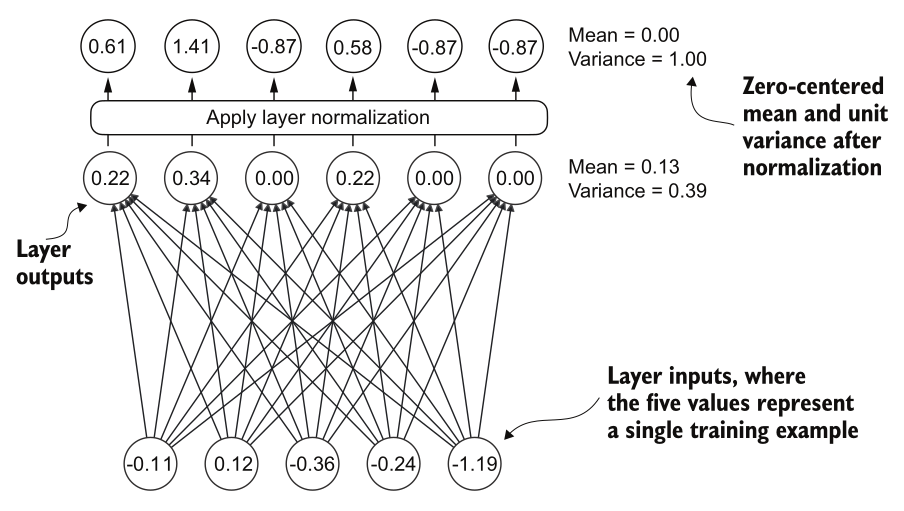

In [3]:
class NormalizationLayer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__() 
        self.epsilon = 1e-5 # we want this to ensure we don't divide by zero
        self.scale = nn.Parameter(torch.ones(emb_dim))  
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift

Above shift and scale are trainable parameters that the LLM adjusts in order to reduce the loss.

The class above performs layer normalization, but notice there are other ways to perform normalization, for example, batch normalization. 

In batch normalization we normalize across the batch dimension. The problem with this approach is that the batch size is not fixed, and it usually depends on the hardware that is running the model. Because of this layer normalization provides more stability.

## Feed Forward Network

We will implement a small neural network submodule used as part of the transformer block. First we will implement the GELU activation function.

The GELU is defined as follows: 

$$ GELU(x) = x \phi(x) $$

where $\phi(x)$ is the cumulative distribution function of the standard Gaussian distribution. In practice we don;t usually implement this, but a computationally more efficient approximation

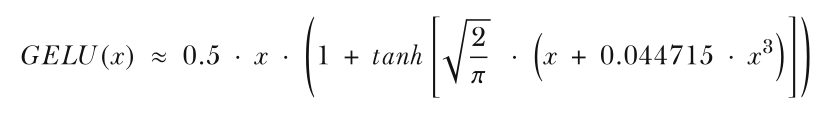

In [4]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

For a comparison of the GELU and ReLU see the following image:

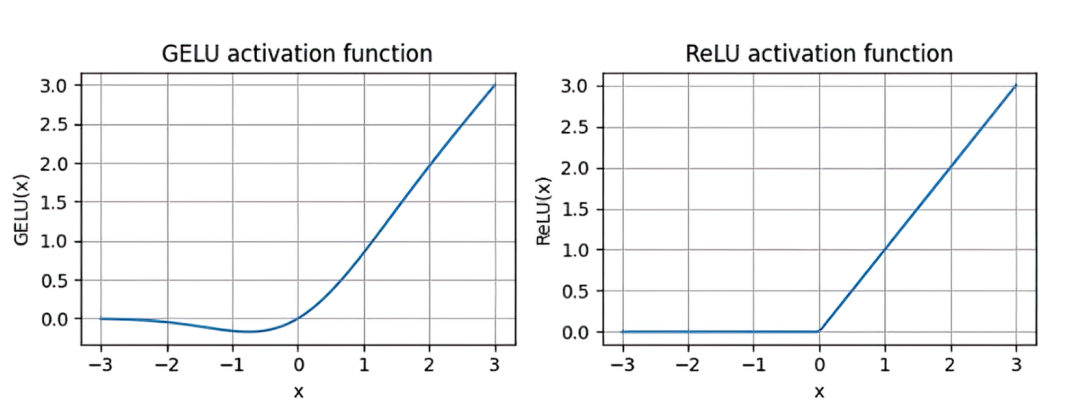

The smoothness of GELU can lead to better optimization properties during training,
as it allows for more nuanced adjustments to the model’s parameters.

Let's now implement a simple feed foward network with GELU activation.

In [5]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

The feedforward module is important since it allows the model to work on a  vector space that is higher dimensional than the vector space the input vectors live in. This allows for the exploration of a much richer representation space.

## Shortcut Connections

Shortcut connections help us with the problem of vanishing gradients. A shortcut connection works by adding the output of a layer to the ouput of another layer.

## Connecting The Attention Module With Linear Layers

Let's implement the *transformer block*. This module, repeated a dozen times in the GPT-2 architecture, uses many of the concepts we have previously covered: self-attention, dropout, normalization, feedfoward networks and GELU.

The whole idea is the that self attention mechanism identifies relationships between elements in the input sequence while the feed forward network modifies the data individually at each position.

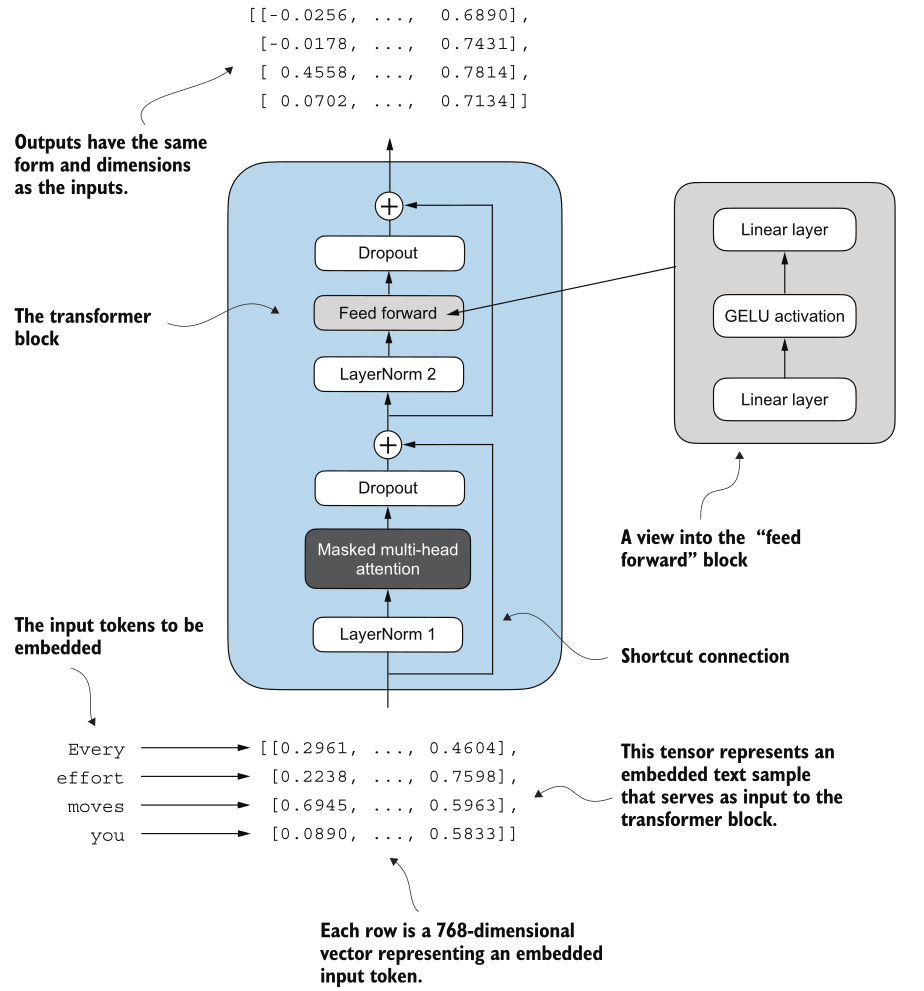

In [6]:
import os
os.chdir("../")

In [7]:
from src.MultiHeadAttention import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.att = MultiHeadAttention(
                d_in=config["emb_dim"],
                d_out=config["emb_dim"],
                context_length=config["context_length"],
                num_heads=config["n_heads"],
                dropout=config["drop_rate"])
        
        self.ff = FeedForward(config=config)
        self.norm1 = NormalizationLayer(config["emb_dim"])
        self.norm2 = NormalizationLayer(config["emb_dim"])
        self.drop_shortcut = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

## Assembling GPT Model

Below is the full architecture of the GPT model. Let's put everything together

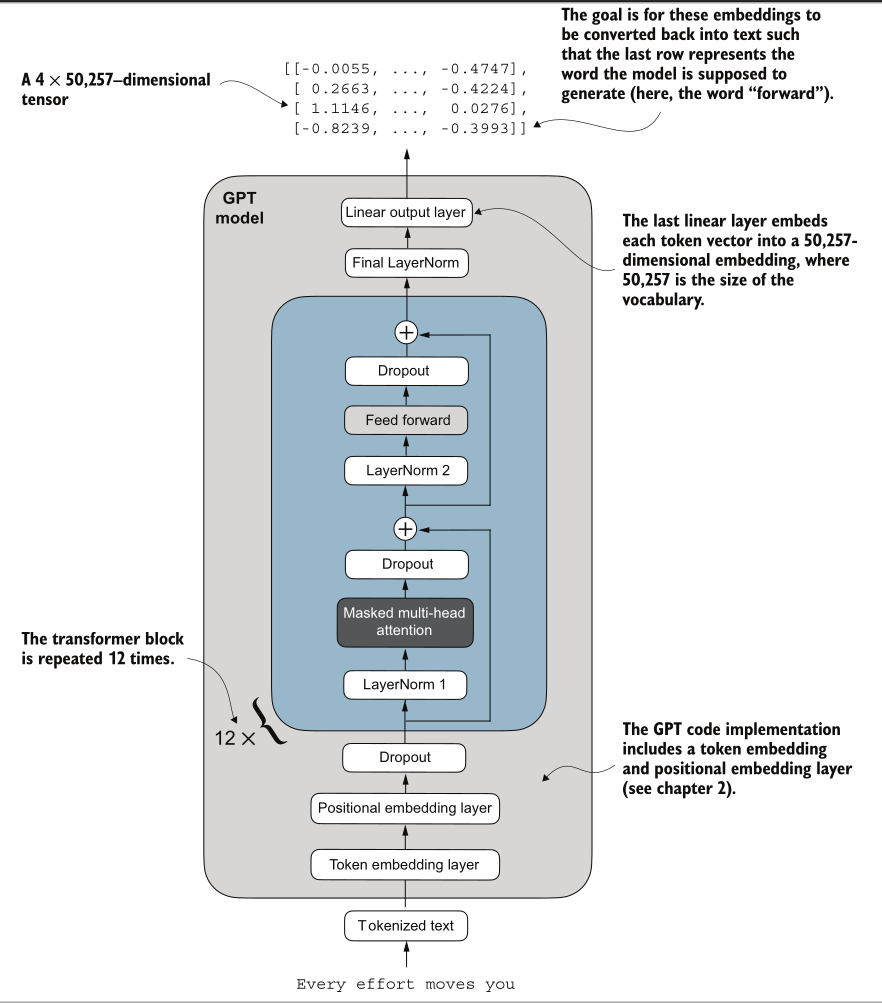

In [8]:
import torch
import torch.nn as nn
from src.MultiHeadAttention import MultiHeadAttention

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.dropout = nn.Dropout(config["drop_rate"])

        self.transformer_block = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])] 
        )

        self.final_normalization = NormalizationLayer(config["emb_dim"])
        
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

    def forward(self, input_IDs):
        batch_size, seq_len = input_IDs.shape
        token_embeds = self.token_emb(input_IDs)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=input_IDs.device))

        x = token_embeds + pos_embeds
        x = self.dropout(x)
        x = self.transformer_block(x)
        x = self.final_normalization(x)
        y = self.out_head(x)
        return y
    


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.att = MultiHeadAttention(
                d_in=config["emb_dim"],
                d_out=config["emb_dim"],
                context_length=config["context_length"],
                num_heads=config["n_heads"],
                dropout=config["drop_rate"])
        
        self.ff = FeedForward(config=config)
        self.norm1 = NormalizationLayer(config["emb_dim"])
        self.norm2 = NormalizationLayer(config["emb_dim"])
        self.drop_shortcut = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
    

class NormalizationLayer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))  # we want this to ensure we don't divide by zero
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


Let's now test with a dummy example

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)


model = GPTModel(GPT2_CONFIG_124M)
out = model(batch)


print(f"Input batch: {batch} \n")

print(f"Output: {out}")
print(out.shape)

Input batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]]) 

Output: tensor([[[ 0.3415,  0.2341,  0.0471,  ...,  1.4781,  1.1591, -0.4735],
         [ 0.4067, -0.3293,  0.1840,  ..., -0.3631,  0.7396,  0.5245],
         [ 0.0728,  0.1965,  0.1965,  ...,  0.6548,  0.0486, -0.0156],
         [ 0.0545,  0.6562, -1.0735,  ...,  0.3423,  0.1639, -0.3807]],

        [[ 0.6078,  0.1699,  0.2014,  ...,  1.5702,  0.7576, -0.7006],
         [ 0.8531,  0.2967,  0.6262,  ..., -0.5984,  0.7886, -0.0655],
         [ 0.5393, -0.6892,  0.1472,  ...,  1.0831, -0.5718, -0.3037],
         [-0.3050,  0.4077, -0.5093,  ...,  1.0447,  0.2350,  0.1522]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 50257])


Notice the the output is of size (2,4,50257) since we passed two input texts with four tokens each. The last dimension corresponds to our vocabulary size.

## Generating Text

The text generation process is illustrated below:

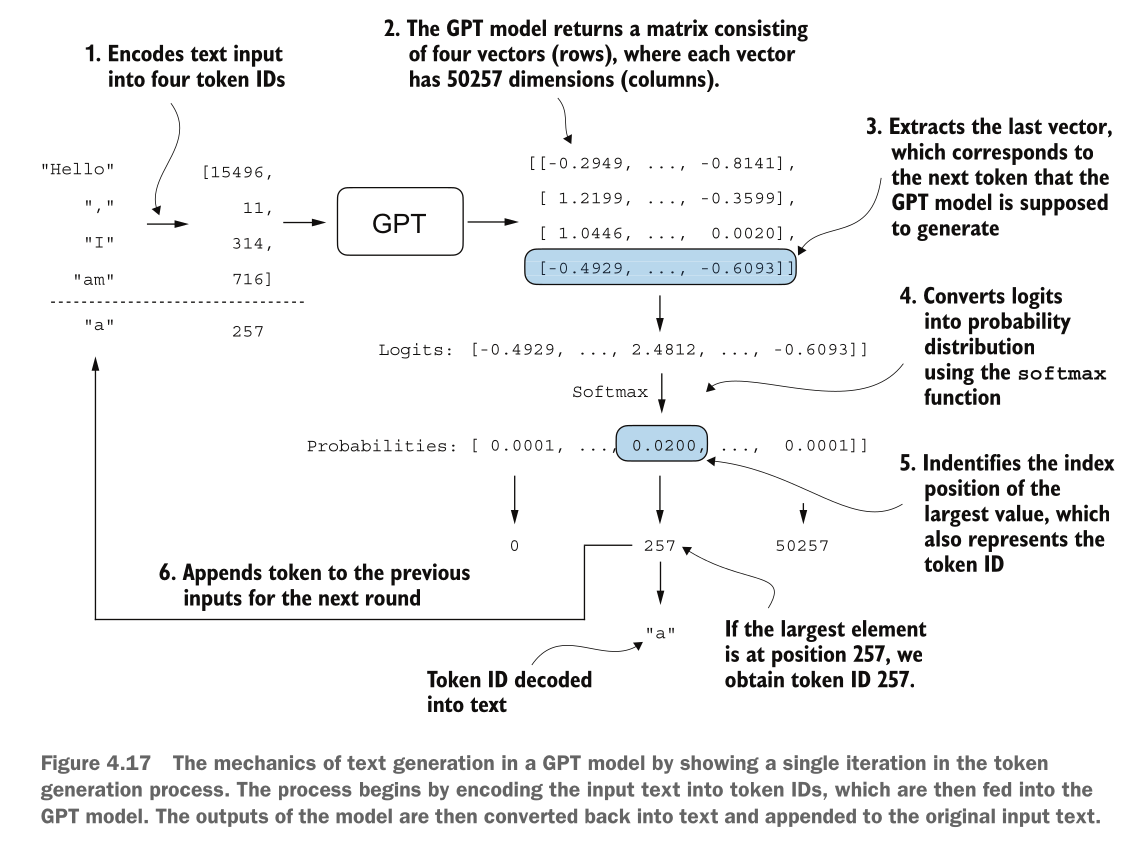

Basically, the input text gets converted into token IDs, and it gets passed to the model which outputs a an embedding for each token. Each of those embeddings represents a "probability distribution". This distribution is the distribution we use to predict the next word, for all tokens up the token that is liked with the current embedding.

In [11]:
def generate_text(model ,token_ids, max_new_tokens, context_size):
    """
    This function will autoregressively generate new tokens

    Args:
        model: the GPT model
        token_ids:  This is a tensor of shape  (batch, seq_len)
        max_new_tokens: This is the number of tokens we want to generate
        context_size: the maximum number of tokens the model can handle at once
    
    Returns:
        Tensor of shape (batch, seq_length + max_new_tokens)

    """
    for _ in range(max_new_tokens):

        token_ids_cond = token_ids[:, -context_size:] # crop to the last context size tokens

        with torch.no_grad():
            logits = model(token_ids_cond)
        
        next_token_logits = logits[:, -1, :] # grab the last token embedding of each batch

        probs = torch.softmax(next_token_logits, dim=-1)

        next_token = torch.argmax(probs, dim=-1, keepdim=True)

        token_ids = torch.cat([token_ids, next_token], dim=1) # adds the new token to the end of each batch
    
    return token_ids




Let's try the function with a simple example

In [14]:
text = "I like pizza"
token_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
print(f"input: {token_ids}")

model.eval()
result = generate_text(model=model, token_ids=token_ids, max_new_tokens=1, context_size=GPT2_CONFIG_124M["context_length"])

print(f"result: {result}")

input: tensor([[   40,   588, 14256]])
result: tensor([[   40,   588, 14256, 31545]])
